## Libraries

In [ ]:
from collections import Counter
from itertools import chain
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from wordcloud import WordCloud
import torch
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)

from emotion_dataset import EmotionDataset
from rnn_lstm_model import RNN_LSTM_model
from loader import loader
from train_model import train_model
from plot_scores import plot_scores
from predict import predict
from predict_on_fly import predict_on_fly
from metrics import compute_metrics, print_metrics, save_metrics

## Device

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


## Load and save dataset

In [55]:
train_csv_path = "data/train.csv"
val_csv_path = "data/val.csv"
test_csv_path = "data/test.csv"

train_df, val_df, test_df = loader(train_csv_path, val_csv_path, test_csv_path)

# Task 1: Data Preparation

## Data set

In [56]:
# Print number of examples
print(f"# train sentences: {len(train_df)}")
print(f"# validation sentences: {len(val_df)}")
print(f"# test sentences: {len(test_df)}")

# Print labels names
print(train_df)

# train sentences: 16000
# validation sentences: 2000
# test sentences: 2000
                                                    text  label label_name
0                                i didnt feel humiliated      0    sadness
1      i can go from feeling so hopeless to so damned...      0    sadness
2       im grabbing a minute to post i feel greedy wrong      3      anger
3      i am ever feeling nostalgic about the fireplac...      2       love
4                                   i am feeling grouchy      3      anger
...                                                  ...    ...        ...
15995  i just had a very brief time in the beanbag an...      0    sadness
15996  i am now turning and i feel pathetic that i am...      0    sadness
15997                     i feel strong and good overall      1        joy
15998  i feel like this was such a rude comment and i...      3      anger
15999  i know a lot but i feel so stupid because i ca...      0    sadness

[16000 rows x 3 column

## Step 1: Dataset Preparation

### Label distribution

Number of classes: 6

Training Label Distribution:
label_name
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64


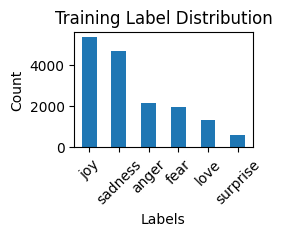

In [57]:
# Create a mapper for label numbers to text labels
num_classes = len(train_df["label"].unique())
print(f"Number of classes: {num_classes}")

# Print the label distribution for training set
train_label_counts = train_df["label_name"].value_counts()
print("\nTraining Label Distribution:")
print(train_label_counts)

# Plot the label distribution
plt.figure(figsize=(2.3, 1.5))
train_label_counts.plot(kind="bar")
plt.title("Training Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## Step 2: Tokenizing

### Tokenizer

In [58]:
tokenizer = RegexpTokenizer(r"[a-zA-Z0-9]+|[!?'´`]+") # characters that don’t match the pattern act as separators.
example_sentence = "This?.is,a:custom;tokenization example!<"
example_tokens = tokenizer.tokenize(example_sentence)
print(example_tokens)

['This', '?', 'is', 'a', 'custom', 'tokenization', 'example', '!']


### Tokenize each split

In [59]:
train_tokens = [tokenizer.tokenize(text.lower()) for text in train_df["text"]]
val_tokens = [tokenizer.tokenize(text.lower()) for text in val_df["text"]]
test_tokens = [tokenizer.tokenize(text.lower()) for text in test_df["text"]]

train_vocab = set(token for tokens in train_tokens for token in tokens)

print(f"# words in train vocab: {len(train_vocab)}")

# words in train vocab: 15212


### Word frequency

   Word  Count
      i  25859
   feel  11183
    and   9589
     to   8972
    the   8370
      a   6200
feeling   5112
   that   5112
     of   4990
     my   4283


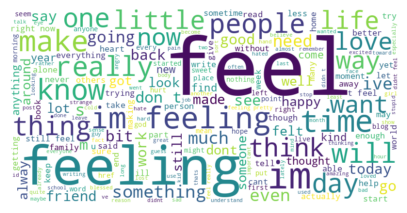

In [ ]:
top_n = 10
flat_tokens = list(chain.from_iterable(train_tokens))
most_common_word_counts = Counter(flat_tokens).most_common(top_n)
print(pd.DataFrame(most_common_word_counts, columns=["Word", "Count"]).to_string(index=False))

In [ ]:
stop_words = set(stopwords.words("english"))
train_tokens = [[word for word in sentence if word not in stop_words] for sentence in train_tokens]

   Word  Count
   feel  11183
feeling   5112
   like   2908
     im   2430
 really    942
   know    853
   time    794
    get    740
 little    736
 people    654


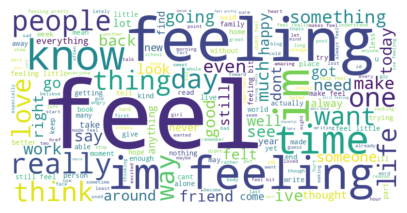

In [ ]:
flat_tokens = list(chain.from_iterable(train_tokens))
most_common_word_counts = Counter(flat_tokens).most_common(top_n)
print(pd.DataFrame(most_common_word_counts, columns=["Word", "Count"]).to_string(index=False))

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(flat_tokens))
plt.figure(figsize=(5, 3))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Sentence length distribution

Length range for train: from 2 to 66 words
Mean length for train: 19 words
Standard deviation for train: 11


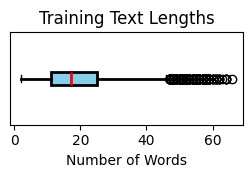

In [60]:
train_lengths = [len(tokens) for tokens in train_tokens]
mean_length = np.mean(train_lengths)
std_dev = np.std(train_lengths)

print(f"Length range for train: from {min(train_lengths)} to {max(train_lengths)} words")
print(f"Mean length for train: {mean_length:.0f} words")
print(f"Standard deviation for train: {std_dev:.0f}")

# Plot
plt.figure(figsize=(3, 1.2))
plt.boxplot(
    train_lengths,
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="skyblue", linewidth=2), # larger, colored box
    whiskerprops=dict(linewidth=2),  # Thicker whiskers
    medianprops=dict(color="red", linewidth=2), # highlight the median
)
plt.title("Training Text Lengths")
plt.xlabel("Number of Words")
plt.yticks([])
plt.show()

## Step 3: Build a vocabulary

In [64]:
vocab = {"<PAD>": 0, "<UNK>": 1}
for tokens in train_tokens:
    for token in tokens:
        if token not in vocab:
            vocab[token] = len(vocab)

vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

reverse_vocab = {v: k for k, v in vocab.items()}

Vocabulary size: 15066


## Step 4: Encode all texts with the vocabulary

In [65]:
def encode_text(tokens): # i.e. words to integers
    return [vocab[token] if token in vocab else 1 for token in tokens]

train_encoded = [encode_text(tokens) for tokens in train_tokens]
val_encoded = [encode_text(tokens) for tokens in val_tokens]
test_encoded = [encode_text(tokens) for tokens in test_tokens]

## Step 5: Maximum sequence length

In [66]:
# Make all sentences equal length.
# - If too small add zeroes at the end.
# - If too long cut the end of the sentence.
max_length = 23

def pad_sequence(sequence):
    return sequence[:max_length] + [0] * (max_length - len(sequence))

train_padded = [pad_sequence(sequence) for sequence in train_encoded]
val_padded = [pad_sequence(sequence) for sequence in val_encoded]
test_padded = [pad_sequence(sequence) for sequence in test_encoded]

# Task 2: RNN model

Epoch 1/10 | Train Loss: 106.086 (acc. 32.3%) | Val Loss: 1.548 (acc. 35.6%) | Time: 3s
Epoch 2/10 | Train Loss: 50.095 (acc. 35.9%) | Val Loss: 1.314 (acc. 41.2%) | Time: 3s
Epoch 3/10 | Train Loss: 24.259 (acc. 43.7%) | Val Loss: 1.308 (acc. 40.5%) | Time: 3s
Epoch 4/10 | Train Loss: 12.075 (acc. 56.5%) | Val Loss: 0.964 (acc. 53.6%) | Time: 3s
Epoch 5/10 | Train Loss: 6.161 (acc. 79.0%) | Val Loss: 0.539 (acc. 82.3%) | Time: 3s
Epoch 6/10 | Train Loss: 3.280 (acc. 91.2%) | Val Loss: 0.444 (acc. 84.3%) | Time: 3s
Epoch 7/10 | Train Loss: 1.952 (acc. 93.3%) | Val Loss: 0.381 (acc. 86.8%) | Time: 3s
Epoch 8/10 | Train Loss: 1.293 (acc. 94.2%) | Val Loss: 0.411 (acc. 85.7%) | Time: 3s
Epoch 9/10 | Train Loss: 0.956 (acc. 94.4%) | Val Loss: 0.441 (acc. 85.2%) | Time: 3s
Epoch 10/10 | Train Loss: 0.759 (acc. 94.8%) | Val Loss: 0.402 (acc. 85.5%) | Time: 3s
Total Training Time: 28s

accuracy: 0.8555
f1: 0.8544
precision: 0.8552
recall: 0.8555
classification report:
              precision 

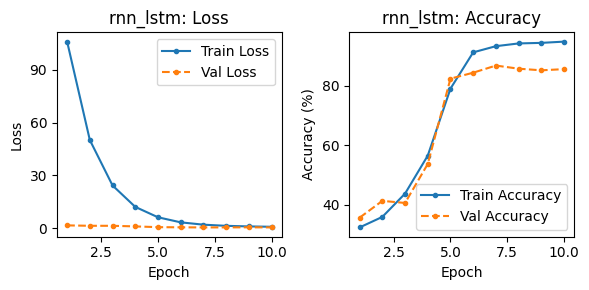

In [67]:
label_map = {label: name for label, name in enumerate(train_df["label_name"].unique())}

embedding_dim = 100
hidden_dim = 256
model = RNN_LSTM_model(vocab_size, embedding_dim, hidden_dim, num_classes, padding_idx=0)

batch_size = 32

train_labels = train_df["label"].tolist()
val_labels = val_df["label"].tolist()
train_dataset = EmotionDataset(train_padded, train_labels)
val_dataset = EmotionDataset(val_padded, val_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

label = "rnn_lstm"
num_epochs = 10
learning_rate = 0.001

results = train_model(
    label=label,
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    label_map=label_map,
    device=device,
    optimizer_type="AdamW",
    learning_rate=learning_rate,
    weight_decay=0.0,
    reg_type="L2",
    reg_lambda=1e-4,
    num_epochs=num_epochs
)

plot_scores(results, label)

In [68]:
predict_on_fly(
    model=model,
    tokenizer=tokenizer,
    vocab=vocab,
    device=device,
    label_map=label_map,
    max_length=max_length
)

Type 'q' to quit.
Exiting...


# Task 3: Transformer model

# Task 4: Analysis

In [69]:
test_labels = test_df["label"].tolist()
test_dataset = EmotionDataset(test_padded, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

predict(label, model, device, test_loader, label_map, reverse_vocab)

accuracy: 0.8515
f1: 0.8509
precision: 0.8528
recall: 0.8515
classification report:
              precision    recall  f1-score   support

     sadness       0.92      0.87      0.89       581
       anger       0.84      0.90      0.87       695
        love       0.73      0.74      0.74       159
    surprise       0.85      0.79      0.82       275
        fear       0.82      0.87      0.84       224
         joy       0.80      0.62      0.70        66

    accuracy                           0.85      2000
   macro avg       0.83      0.80      0.81      2000
weighted avg       0.85      0.85      0.85      2000

confusion matrix:
[506, 51, 3, 12, 8, 1]
[13, 628, 36, 10, 2, 6]
[2, 31, 118, 6, 1, 1]
[17, 25, 4, 216, 12, 1]
[11, 7, 1, 10, 194, 1]
[1, 3, 0, 1, 20, 41]



# Task 5: Pre-trained model (transfer learning)

In [70]:
model_name = "roberta-base"
num_epochs = 10
learning_rate = 3e-5

def pretrained_evaluation(predictions):
    preds = predictions.predictions.argmax(-1) # get predicted labels
    labels = predictions.label_ids
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

def preprocess_function(texts, labels, tokenizer, max_length):
    encodings = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    return {
        "input_ids": encodings["input_ids"],
        "attention_mask": encodings["attention_mask"],
        "label": labels
    }

# Load pre-trained tokenizer
tokenizer_pretrained = AutoTokenizer.from_pretrained(model_name)

# Preprocess train and validation datasets
train_encodings = preprocess_function(train_df["text"].tolist(), train_labels, tokenizer_pretrained, max_length)
val_encodings = preprocess_function(val_df["text"].tolist(), val_labels, tokenizer_pretrained, max_length)

# Convert to Hugging Face Dataset
train_data = Dataset.from_dict(train_encodings)
val_data = Dataset.from_dict(val_encodings)

# Set format for PyTorch
train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Load pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

# Training arguments
training_args = TrainingArguments(
    output_dir="results",
    evaluation_strategy="epoch", # evaluate at end of each epoch
    save_strategy="epoch", # save checkpoints after every epoch
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    load_best_model_at_end=True, # load best model at end of training
    metric_for_best_model="accuracy",  # specify metric to monitor
    save_total_limit=1, # keep only best checkpoint
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    compute_metrics=pretrained_evaluation, # compute metrics during evaluation
)

# Train model
trainer.train()

# Evaluate best model
best_results = trainer.evaluate()
print(f"Best Model Evaluation Results:\n {best_results}")

# Save best fine-tuned model
trainer.save_model(f"models/{model_name}")
tokenizer_pretrained.save_pretrained(f"models/{model_name}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\henri\miniconda3\envs\deep\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
                                                 
  0%|          | 11/5000 [02:56<08:31,  9.75it/s] 

{'loss': 0.6311, 'grad_norm': 14.768756866455078, 'learning_rate': 2.7000000000000002e-05, 'epoch': 1.0}















                                                 
                                               

  0%|          | 11/5000 [02:57<08:31,  9.75it/s]



{'eval_loss': 0.3556743562221527, 'eval_accuracy': 0.869, 'eval_f1': 0.8692500038556334, 'eval_precision': 0.8772472258827019, 'eval_recall': 0.869, 'eval_runtime': 1.5015, 'eval_samples_per_second': 1331.974, 'eval_steps_per_second': 41.957, 'epoch': 1.0}


KeyboardInterrupt: 

In [ ]:
# Load trained tokenizer and model
tokenizer_new = AutoTokenizer.from_pretrained(f"models/{model_name}")
model_new = AutoModelForSequenceClassification.from_pretrained(f"models/{model_name}", num_labels=num_classes)

# Preprocess test data
test_encodings = preprocess_function(test_df["text"].tolist(), test_df["label"].tolist(), tokenizer_new, max_length)

# Convert to Hugging Face Dataset
test_dataset = Dataset.from_dict(test_encodings)
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Define Trainer (ensure it uses the pre-trained model)
trainer = Trainer(model=model_new)

# Make predictions using the Trainer
predictions = trainer.predict(test_dataset)

# Extract logits and compute predicted labels
logits = torch.tensor(predictions.predictions) # convert logits to a PyTorch tensor
predicted_labels = torch.argmax(logits, dim=1).numpy() # convert to numpy array for sklearn metrics

# Evaluate predictions
# label mapping from integer to text labels
metrics = compute_metrics(test_df["label"], predicted_labels, label_map.values())
print_metrics(metrics)
save_metrics(model_name, metrics)

100%|██████████| 250/250 [00:02<00:00, 88.11it/s]

accuracy: 0.8605
f1: 0.8612
precision: 0.8639
recall: 0.8605
classification report:
              precision    recall  f1-score   support

     sadness       0.88      0.91      0.90       581
       anger       0.89      0.87      0.88       695
        love       0.72      0.77      0.75       159
    surprise       0.91      0.83      0.87       275
        fear       0.84      0.79      0.82       224
         joy       0.65      0.85      0.74        66

    accuracy                           0.86      2000
   macro avg       0.82      0.84      0.82      2000
weighted avg       0.86      0.86      0.86      2000

confusion matrix:
[531, 22, 2, 10, 16, 0]
[26, 605, 43, 7, 7, 7]
[10, 21, 123, 3, 1, 1]
[19, 18, 1, 229, 8, 0]
[13, 7, 1, 4, 177, 22]
[4, 4, 1, 0, 1, 56]

